In [1]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()
from modules.la import get_la_df, get_la_with_leagues


In [ ]:

df = get_la_with_leagues()
updated_buckets = []

## Population by league

Different leagues need different useful population selectors. This notebook tries to get reasonably useful groupings of population size, so that councils are in general more similar to each other inside the group, but also no individual group is too larger. 

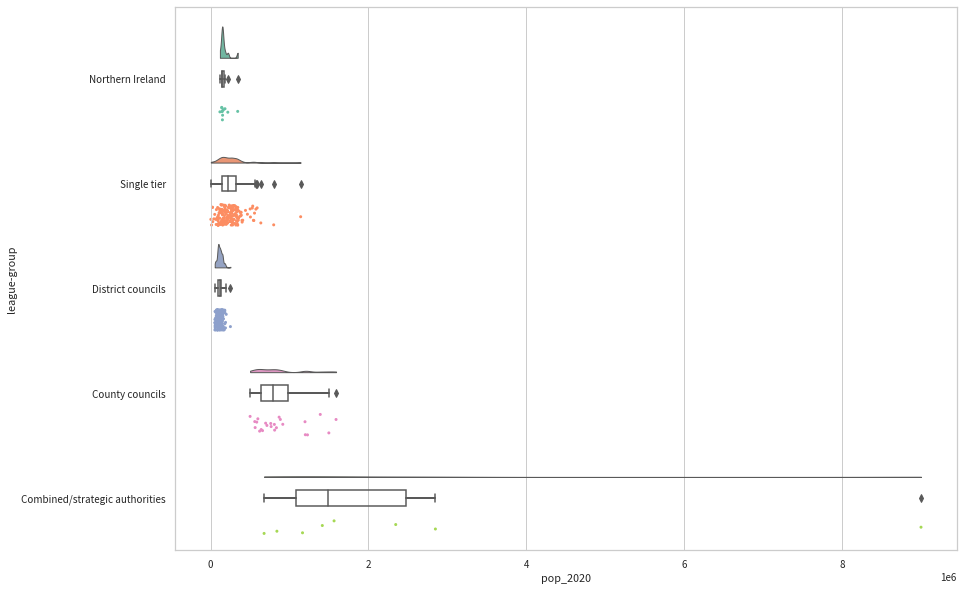

In [2]:
df.viz.raincloud("pop_2020", "league-group")

The above raincloud plot shows the variation on population size by league. 

Generally the Northern Ireland and Combined/strategic authorities league seem too small to make big distinctions.

The rest need to be drilled into in more detail. 

## Northern Ireland

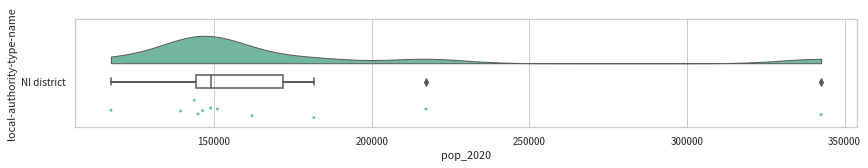

local-authority-code,official-name,pop_2020
BFS,Belfast City Council,"342,560.0"
ABC,"Armagh City, Banbridge and Craigavon Borough Council","217,232.0"
NMD,"Newry, Mourne and Down District Council","181,669.0"
AND,Ards and North Down Borough Council,"162,056.0"
DRS,Derry City and Strabane District Council,"151,109.0"
MUL,Mid Ulster District Council,"148,953.0"
LBC,Lisburn and Castlereagh City Council,"146,452.0"
CCG,Causeway Coast and Glens Borough Council,"144,943.0"
ANN,Antrim and Newtownabbey Borough Council,"143,756.0"
MEA,Mid and East Antrim Borough Council,"139,443.0"


In [3]:
d = df[df["league-group"] == "Northern Ireland"]
d.viz.raincloud("pop_2020", "local-authority-type-name")
(d[["local-authority-code", "official-name", "pop_2020"]]
 .sort_values("pop_2020", ascending=False)
 .style.hide_index()
 .format({"pop_2020": comma_thousands}))


Here there are several clear outliers, but they're urban areas, so I think a basic urban/rural split should be be enough. Ignore population for NI.  

## County councils

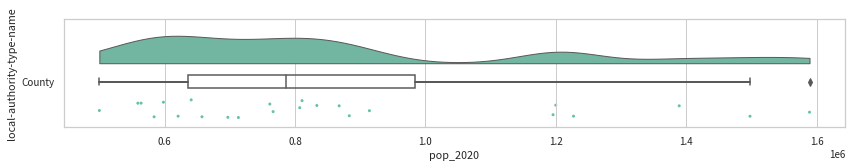

local-authority-code,official-name,pop_2020
KEN,Kent County Council,"1,589,057.0"
ESS,Essex County Council,"1,497,759.0"
HAM,Hampshire County Council,"1,389,206.0"
LAN,Lancashire County Council,"1,227,076.0"
SRY,Surrey County Council,"1,199,870.0"
HRT,Hertfordshire County Council,"1,195,672.0"
NFK,Norfolk County Council,"914,039.0"
STS,Staffordshire County Council,"883,172.0"
WSX,West Sussex County Council,"867,635.0"
NTT,Nottinghamshire County Council,"833,377.0"


In [4]:
d = df[df["league-group"] == "County councils"]
d.viz.raincloud("pop_2020", "local-authority-type-name")

(d[["local-authority-code", "official-name", "pop_2020"]]
 .sort_values("pop_2020", ascending=False)
 .style.hide_index()
 .format({"pop_2020": comma_thousands}))

This suggests thresholds at 1m, 800k to give three groups. 

In [5]:
def sorter(v) -> str:
    if v > 1000000:
        return "1m +"
    elif v > 800000:
        return "800k - 1m"
    else:
        return "under 800k"


d["pop_bucket"] = d["pop_2020"].apply(sorter)

new_buckets = d.set_index("local-authority-code")["pop_bucket"]
updated_buckets.append(new_buckets)


## Single tier councils

This is a harder problem in that most are in a range, and there are only a few outliers. 


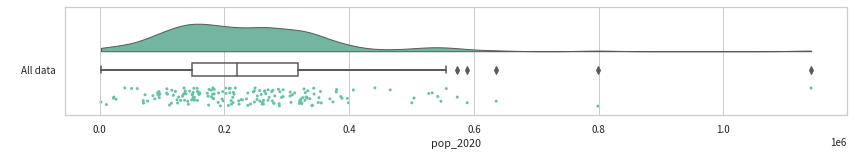

In [6]:
sdf = df[df["league-group"] == "Single tier"]
sdf["pop_2020"].viz.raincloud()


This is nothing to do with the underlying authority type, which vary a bit, but generally mostly within nations. 

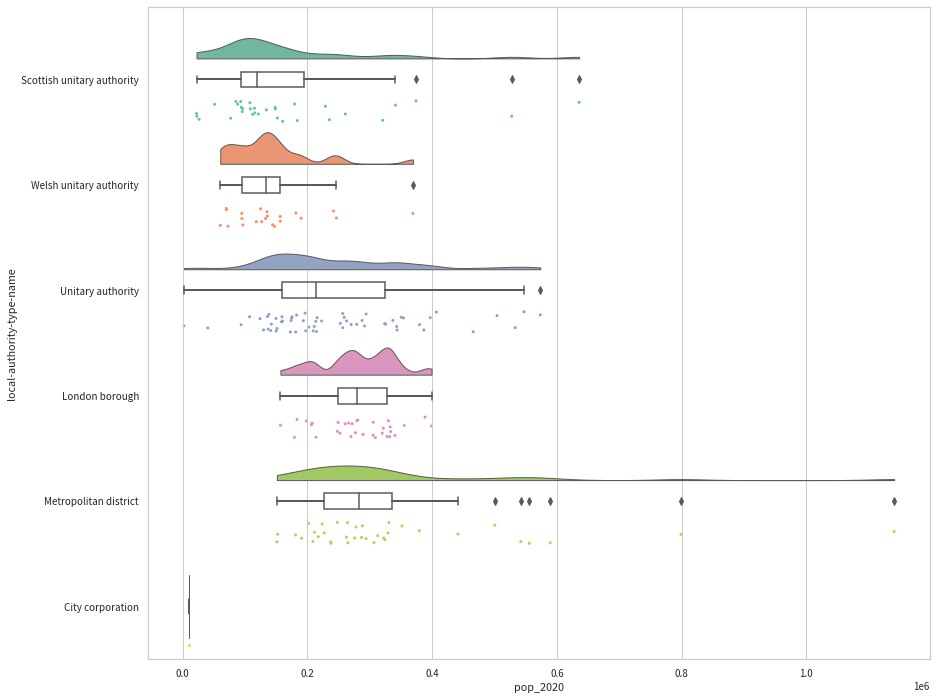

In [7]:

sdf.viz.raincloud("pop_2020", "local-authority-type-name")


There are three possible ways of splitting this into buckets:

* Equal ranges (Each population range represents the same jump in population)
* Equal sized buckets (each population range has an equal number of councils)
* Clustered approach (councils are more similar to councils in their cluster than those in other clusters)

There doesn't seem a good user reason for equal ranges, so we'll start looking at a clustered approach. 

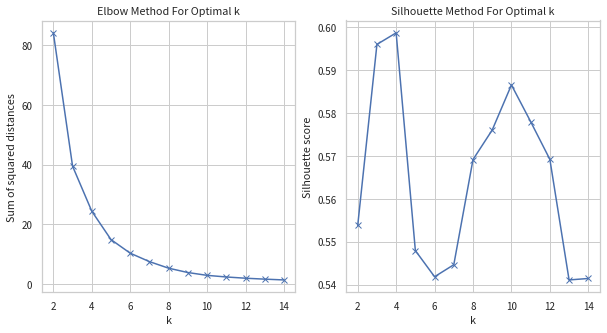

In [8]:
c = sdf.space.cluster("local-authority-code", cols=["pop_2020"])
c.find_k()


The above graph suggests clusters are most coherent at 4 and 10. Checking sizes at 4 clustesr:

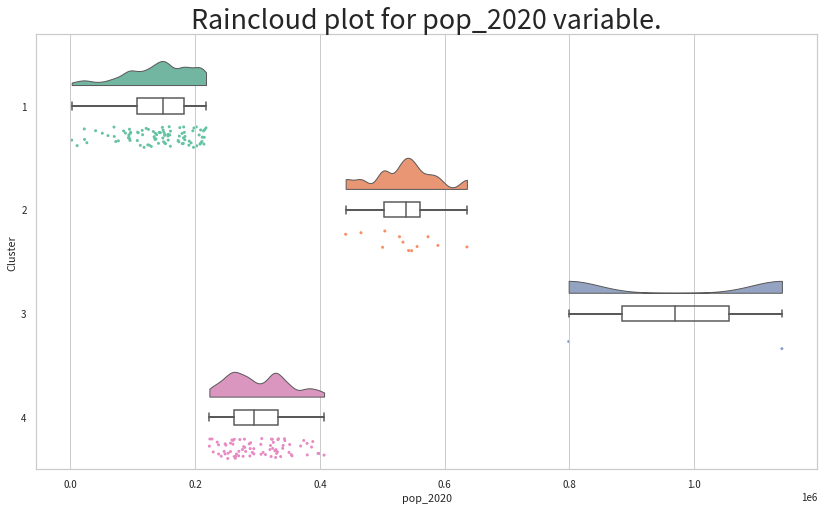

,count,%,random members
labels,,,
1,91,50.0,"[RCC, SOL, FLN, MON, NWP]"
2,12,6.6,"[GLG, EDH, WIL, DUR, KIR]"
3,2,1.1,"[LDS, BIR]"
4,77,42.3,"[SKP, FIF, ABE, NET, WGN]"


In [9]:
c.set_k(4)
c.raincloud("pop_2020")
c.stats()

Most clusters fall intwo two mainstream clusters (which are too big for our purposes). I think my approach should be to remerge 4 and 1, and then split into 4 equal sized buckets. 

In [10]:
lsdf = c.df_with_labels()

lsdf["label"] = lsdf["label"].apply(lambda x: {2:1}.get(x,x))

# split combined cluster into 4 and reimport
d = lsdf["pop_2020"][lsdf["label"] == 1]
d = pd.qcut(d, q=4, labels=[5,6,7,8]).astype(int)
lsdf["label"].update(d)


In [11]:
def round_nice(v):
    v = int(v)
    v = round(v, -4)
    return f"{int(v/1000)}k"

def get_min_max(df):
    min = round_nice(df["pop_2020"].min())
    max = round_nice(df["pop_2020"].max())
    return f"{min} - {max}"

label_lookup = lsdf.groupby("label").apply(get_min_max)
lsdf["pop_bucket"] = lsdf["label"].map(label_lookup.to_dict())

new_buckets = lsdf.set_index("local-authority-code")["pop_bucket"]
updated_buckets.append(new_buckets)

ld = pd.DataFrame()
ld["label"] = label_lookup
ld["number"] = label_lookup.str.split("-").str[0].str.strip().str[:-1].astype(int)
order_key = ld.set_index("label")["number"].to_dict()

lsdf.pivot_table("local-authority-code", index="pop_bucket", aggfunc="count").sort_index(key=lambda x: x.to_series().apply(order_key.get))

,local-authority-code
pop_bucket,
0k - 110k,26
120k - 150k,26
150k - 200k,25
200k - 640k,26
220k - 410k,77
800k - 1140k,2


# District councils

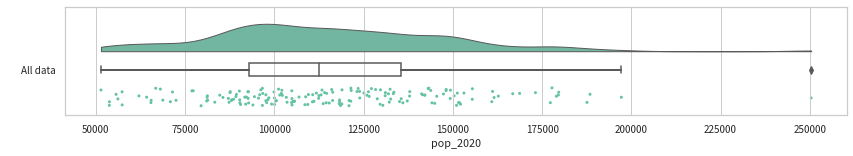

In [12]:
ddf = df[df["league-group"] == "District councils"]
ddf["pop_2020"].viz.raincloud()


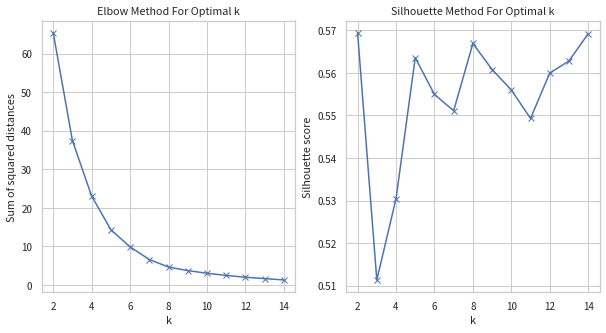

In [13]:
c = ddf.space.cluster("local-authority-code", cols=["pop_2020"])
c.find_k()


This one has a good peak around 5. Again, will need to combine and then split clusters 1 and 2. 

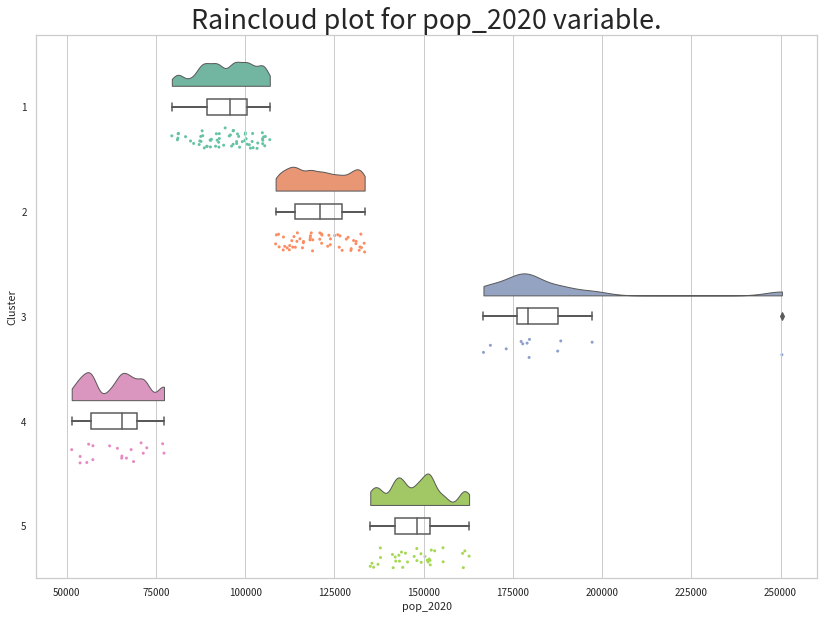

,count,%,random members
labels,,,
1,62,34.3,"[HER, MDE, STF, HAR, WAT]"
2,53,29.3,"[HAA, ASH, DOV, NHE, NEC]"
3,12,6.6,"[BAN, CAT, MAI, SSO, WSK]"
4,19,10.5,"[MAL, ROS, COP, MEL, RYE]"
5,35,19.3,"[SAL, EAT, IPS, THA, KIN]"


In [14]:
c.set_k(5)
c.raincloud("pop_2020")
c.stats()

In [15]:
lsdf = c.df_with_labels()

# merge cluster 2 into 1

lsdf["label"] = lsdf["label"].apply(lambda x: {2: 1}.get(x, x))

# split combined cluster into 4
d = lsdf["pop_2020"][lsdf["label"] == 1]
d = pd.qcut(d, q=4, labels=[10, 11, 12, 13]).astype(int)
lsdf["label"].update(d)

def round_nice(v: int) -> str:
    v = round(v, -4)
    return f"{int(v/1000)}k"


def get_min_max(df: pd.DataFrame) -> str:
    min = round_nice(df["pop_2020"].min())
    max = round_nice(df["pop_2020"].max())
    return f"{min} - {max}"


label_lookup = lsdf.groupby("label").apply(get_min_max)
lsdf["pop_bucket"] = lsdf["label"].map(label_lookup.to_dict())

new_buckets = lsdf.set_index("local-authority-code")["pop_bucket"]
updated_buckets.append(new_buckets)


ld = pd.DataFrame({"label": label_lookup})
ld["number"] = label_lookup.str.split(
    "-").str[0].str.strip().str[:-1].astype(int)
order_key = ld.set_index("label")["number"].to_dict()

(lsdf
 .pivot_table("local-authority-code", index="pop_bucket", aggfunc="count")
 .sort_index(key=lambda x: x.to_series().apply(order_key.get)))


,local-authority-code
pop_bucket,
50k - 80k,19
80k - 90k,29
90k - 100k,29
110k - 120k,28
120k - 130k,29
140k - 160k,35
170k - 250k,12


# Recombine into final dataset

In [16]:
df = get_la_with_leagues().set_index("local-authority-code")

df["pop_bucket"] = "NA"

for bucket in updated_buckets:
    df["pop_bucket"].update(bucket)

df = df.reset_index()
# export this data
cols = ["local-authority-code","official-name", "league-group", "pop_2020", "pop_bucket"]
df[cols].to_csv(Path("data", "outputs", "pop_buckets.csv"), index=False)